# Test Slingshot MST

Mamie Wang 05/14/2020

- Goal: compare MST constructed with edge weight as Euclidean distance vs 1/similarity on two simulated datasets using Slingshot 
- The two simulated datasets (single lineage, bifurcation) is demonstrated here: https://github.com/kstreet13/slingshot/blob/master/vignettes/vignette.Rmd

In [2]:
library(SingleCellExperiment)
library(slingshot)
library(tidyverse)
library(destiny)
library(mclust)
library(RColorBrewer)

## Single lineage

In [3]:
# example of five types of gene trajectory
example <- data.frame(
    index = 1:300,
    early_deact = exp(atan( ((300:1)-200)/50 )),
    late_deact = exp(atan( ((300:1)-100)/50 )),
    early_act = exp(atan( ((1:300)-100)/50 )),
    late_act = exp(atan( ((1:300)-200)/50 )),
    transient = exp(atan( c((1:100)/33, rep(3,100), (100:1)/33) )))

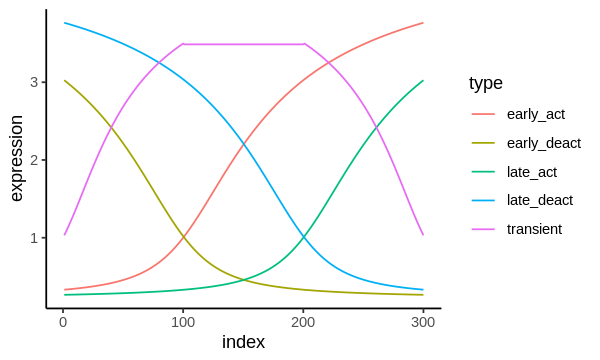

In [4]:
options(repr.plot.width = 5, repr.plot.height = 3)
example %>%
    tidyr::gather(type, expression, -index) %>%
    ggplot(data = .) +
        geom_line(aes(x = index, y = expression, color = type)) +
        theme_classic() 

In [5]:
set.seed(12345)

# simulate 300 cells x 750 genes:
means <- rbind(
    # 500 non-DE genes
    matrix(rep(rep(c(0.1,0.5,1,2,3), each = 300),100),
        ncol = 300, byrow = TRUE),
    # 50 early deactivation
    matrix(rep(exp(atan( ((300:1)-200)/50 )),50), ncol = 300, byrow = TRUE),
    # 50 late deactivation
    matrix(rep(exp(atan( ((300:1)-100)/50 )),50), ncol = 300, byrow = TRUE),
    # 50 early activation
    matrix(rep(exp(atan( ((1:300)-100)/50 )),50), ncol = 300, byrow = TRUE),
    # 50 late activation
    matrix(rep(exp(atan( ((1:300)-200)/50 )),50), ncol = 300, byrow = TRUE),
    # 50 transient
    matrix(rep(exp(atan( c((1:100)/33, rep(3,100), (100:1)/33) )),50), 
        ncol = 300, byrow = TRUE)
)

# sample the total counts per cell from a negative binomial
# sample the gene counts per cell from a mvn
counts <- apply(means,2,function(cell_means){
    total <- rnbinom(1, mu = 7500, size = 4)
    rmultinom(1, total, cell_means)
})
rownames(counts) <- paste0('G',1:750)
colnames(counts) <- paste0('c',1:300)
sim <- SingleCellExperiment(assays = List(counts = counts))

In [6]:
# gene filtering
geneFilter <- apply(assays(sim)$counts,1,function(x){
    sum(x >= 3) >= 10
})
sim <- sim[geneFilter, ]

In [7]:
# quantile normalization that force each cell to have the same
# distribution of expression (no need to worry about batch effect since
# it is simulated)
FQnorm <- function(counts){
    rk <- apply(counts,2,rank,ties.method='min')
    counts.sort <- apply(counts,2,sort)
    refdist <- apply(counts.sort,1,median)
    norm <- apply(rk,2,function(r){ refdist[r] })
    rownames(norm) <- rownames(counts)
    return(norm)
}
assays(sim)$norm <- FQnorm(assays(sim)$counts)

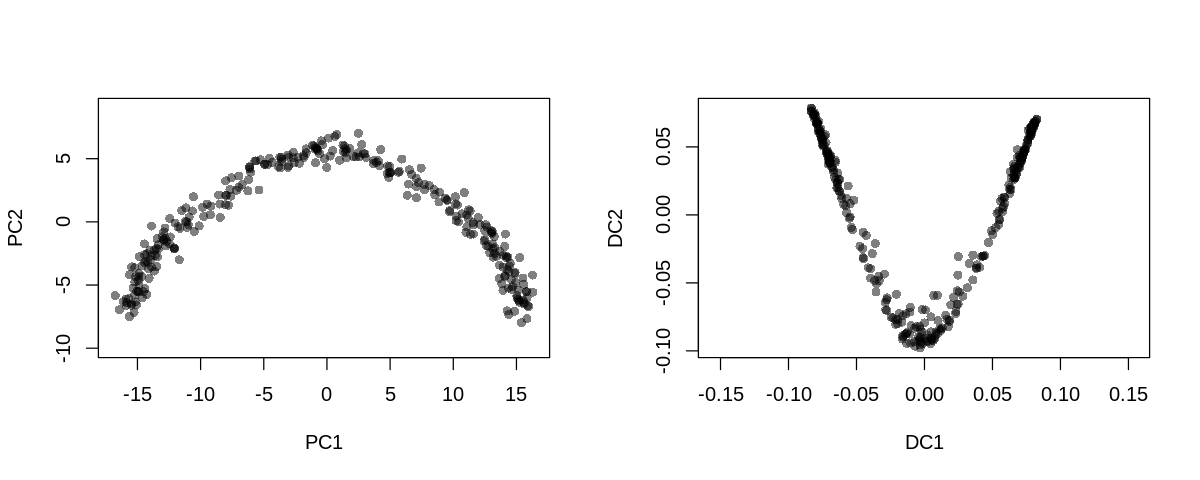

In [8]:
# dimension reduction
options(repr.plot.width = 10, repr.plot.height = 4)
par(mfrow = c(1, 2))

# PCA
pca <- prcomp(t(log1p(assays(sim)$norm)), scale. = FALSE)
rd1 <- pca$x[,1:2]
plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

# diffusion map
dm <- DiffusionMap(t(log1p(assays(sim)$norm)), n_pcs = 50)
rd2 <- cbind(DC1 = dm$DC1, DC2 = dm$DC2)
plot(rd2, col = rgb(0,0,0,.5), pch=16, asp = 1)

In [9]:
# pca and diffusion map object to the sc object
reducedDims(sim) <- SimpleList(PCA = rd1, DiffMap = rd2)

# clustering (kmeans clustering with k = 4)
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sim)$kmeans <- cl2

Using full covariance matrix


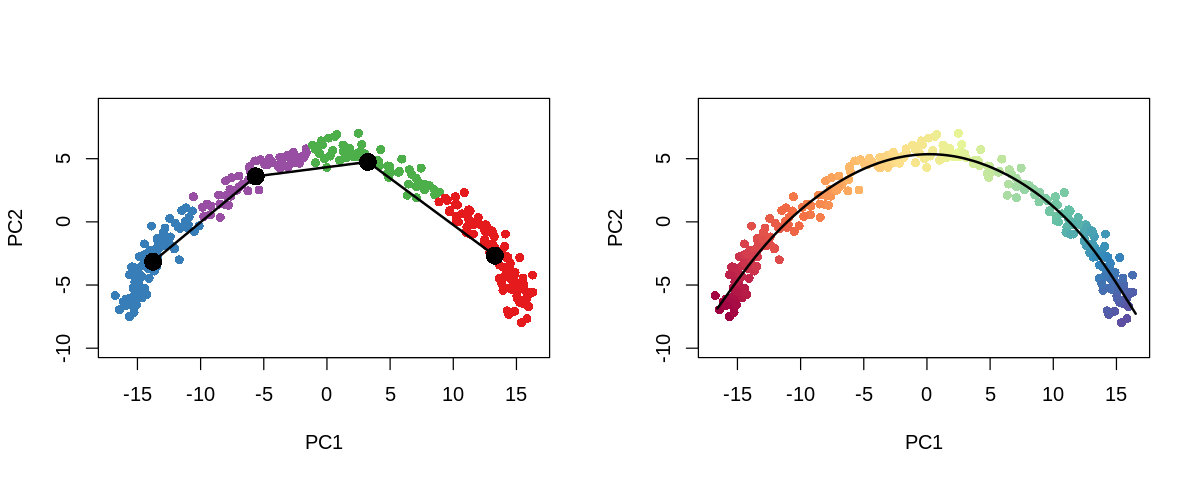

In [10]:
# applying slighshot on the clusters
options(repr.plot.width = 10, repr.plot.height = 4)
par(mfrow = c(1, 2))
sim <- slingshot(sim, clusterLabels = 'kmeans', reducedDim = 'PCA')
plot(reducedDims(sim)$PCA, col = brewer.pal(9,'Set1')[sim$kmeans], pch=16, asp = 1)
lines(SlingshotDataSet(sim), lwd=2, type = 'lineages', col = 'black')

# plotting the pseudotime on the PCA plot
# summary(sim$slingPseudotime_1)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sim$slingPseudotime_1, breaks=100)]
plot(reducedDims(sim)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sim), lwd=2, col='black')

## MST on single cells

In [46]:
# the required input to dist.fun has three arguments
# X: full data matrix
# w1: cluster membership for cluster 1 (can be probability)
# w2: cluster membership for cluster 2 (can be probability)

# Euclidean distance 
euc_dist <- function(X, w1, w2) {
    if(length(w1) != nrow(X) | length(w2) != nrow(X)){
        stop("Reduced dimensional matrix and weights vector contain different
             numbers of points.")
    }
    mu1 <- colWeightedMeans(X, w = w1)
    mu2 <- colWeightedMeans(X, w = w2)
    diff <- mu1 - mu2
    d <- sqrt(t(diff) %*% diff)
    return(d)
}

# 1/similarity
inverse_sim <- function(X, w1, w2, lambda = 2) {
    if(length(w1) != nrow(X) | length(w2) != nrow(X)){
        stop("Reduced dimensional matrix and weights vector contain different
             numbers of points.")
    }
    mu1 <- colWeightedMeans(X, w = w1)
    mu2 <- colWeightedMeans(X, w = w2)
    diff <- mu1 - mu2
    d_sq <- t(diff) %*% diff
    inv_sim <- 1/exp(-d_sq/lambda)
    return(inv_sim)
}

In [16]:
cl_sc <- seq(300)

lin2 <- getLineages(pca$x[,1:6], cl_sc, dist.fun = euc_dist)
lin3 <- getLineages(pca$x[,1:6], cl_sc, dist.fun = inverse_sim)

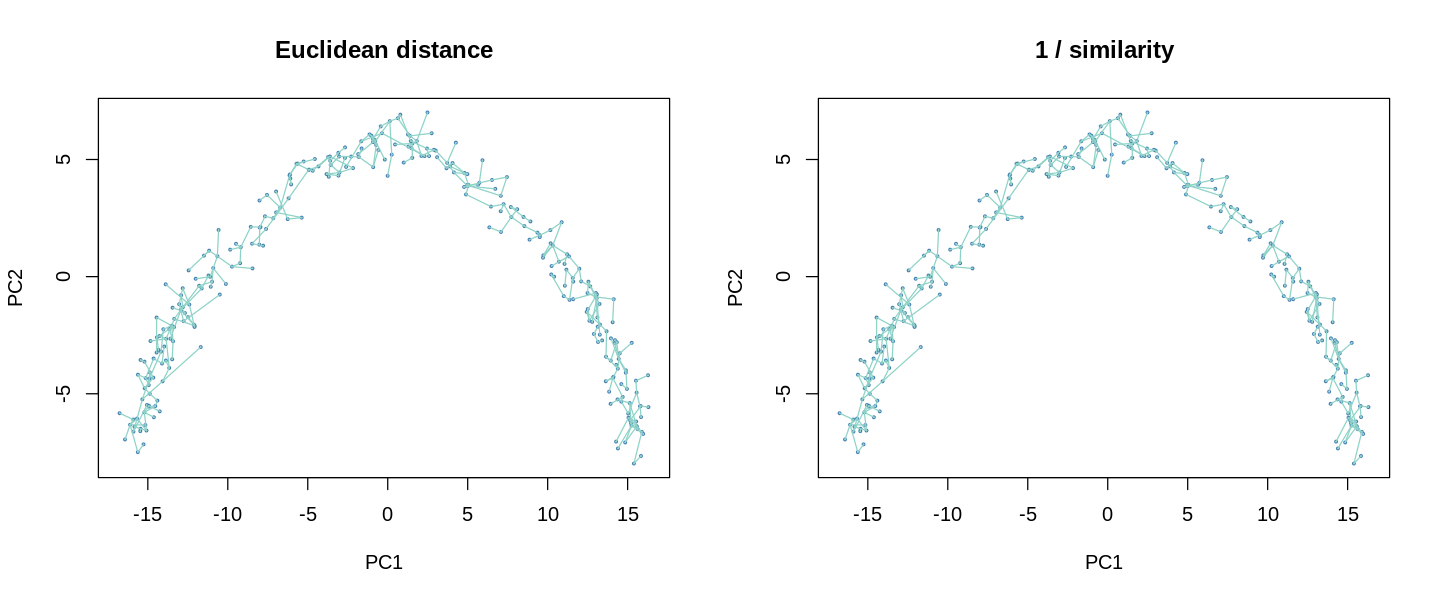

In [17]:
options(repr.plot.width = 12, repr.plot.height = 5)
par(mfrow = c(1, 2))
plot(pca$x[,1:2], col = "steelblue", cex = 0.3, main = "Euclidean distance")
lines(lin2, cex = 0.1, lwd = 1, type = "l")

plot(pca$x[,1:2], col = "steelblue", cex = 0.3, main = "1 / similarity")
lines(lin3, cex = 0.1, lwd = 1, type = "l")

## MST on clusters

In [47]:
lin4 <- getLineages(pca$x[,1:6], cl2, dist.fun = euc_dist)

In [48]:
lin5 <- getLineages(pca$x[,1:6], cl2, dist.fun = function(X, w1, w2) inverse_sim(X, w1, w2, lambda = 100))

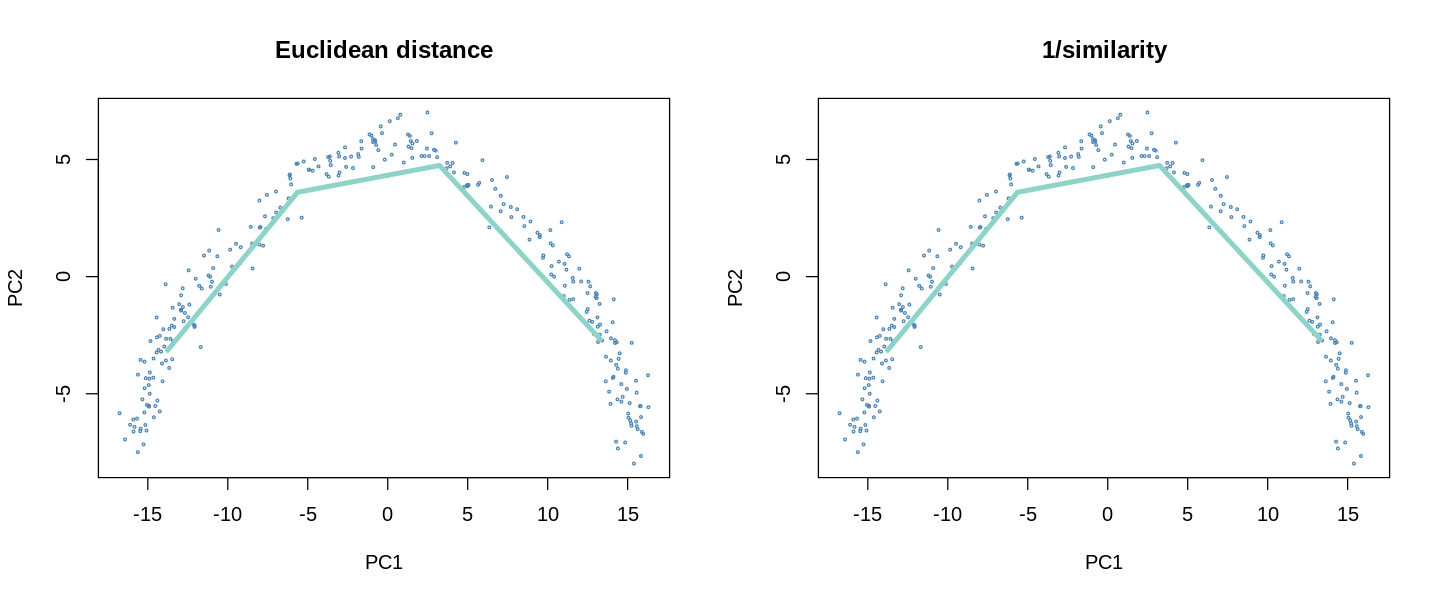

In [49]:
options(repr.plot.width = 12, repr.plot.height = 5)
par(mfrow = c(1, 2))
plot(pca$x[,1:2], col = "steelblue", cex = 0.3, main = "Euclidean distance")
lines(lin4, cex = 0.1, lwd = 4, type = "l")
plot(pca$x[,1:2], col = "steelblue", cex = 0.3, main = "1/similarity")
lines(lin5, cex = 0.1, lwd = 4, type = "l")

## Bifurcation

In [50]:
# bifurcating dataset
data("slingshotExample")

Using full covariance matrix


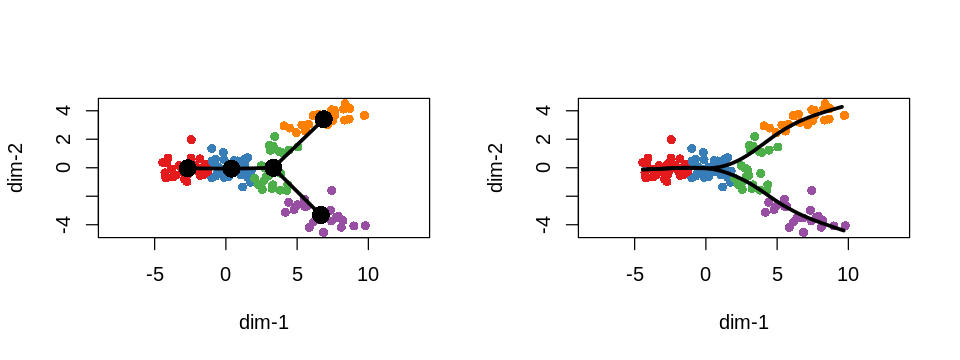

In [51]:
# get lineage structure and get curve function from the MST
lin1 <- getLineages(rd, cl)
crv1 <- getCurves(lin1)

options(repr.plot.width = 8, repr.plot.height = 3)
par(mfrow = c(1, 2))
plot(rd, col = brewer.pal(9,"Set1")[cl], asp = 1, pch = 16)
lines(lin1, lwd = 3, col = 'black')
plot(rd, col = brewer.pal(9,"Set1")[cl], asp = 1, pch = 16)
lines(crv1, lwd = 3, col = 'black')

### Single cell MST

In [53]:
cl_sc <- seq(140)

lin2 <- getLineages(rd, cl_sc, dist.fun = euc_dist)
lin3 <- getLineages(rd, cl_sc, dist.fun = inverse_sim)

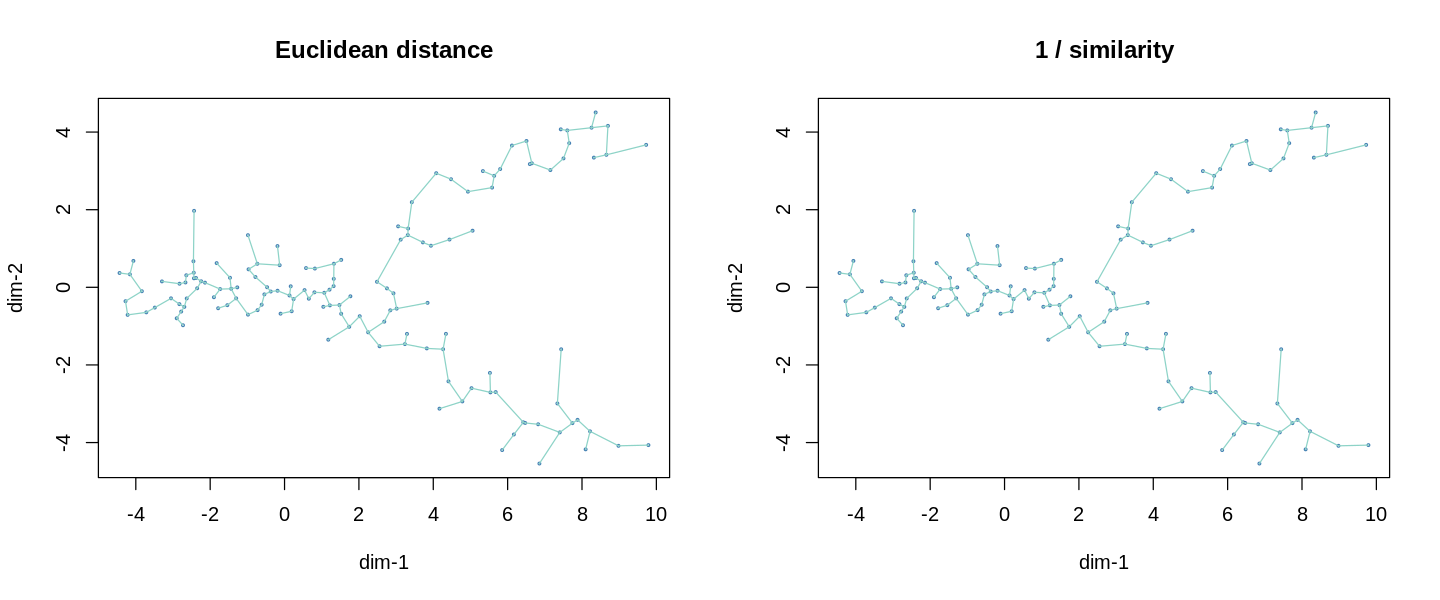

In [54]:
options(repr.plot.width = 12, repr.plot.height = 5)
par(mfrow = c(1, 2))
plot(rd, col = "steelblue", cex = 0.3, main = "Euclidean distance")
lines(lin2, cex = 0.1, lwd = 1, type = "l")

plot(rd, col = "steelblue", cex = 0.3, main = "1 / similarity")
lines(lin3, cex = 0.1, lwd = 1, type = "l")

## MST on clusters

In [55]:
lin4 <- getLineages(rd, cl, dist.fun = euc_dist)

In [56]:
lin5 <- getLineages(rd, cl, dist.fun = function(X, w1, w2) inverse_sim(X, w1, w2, lambda = 100))

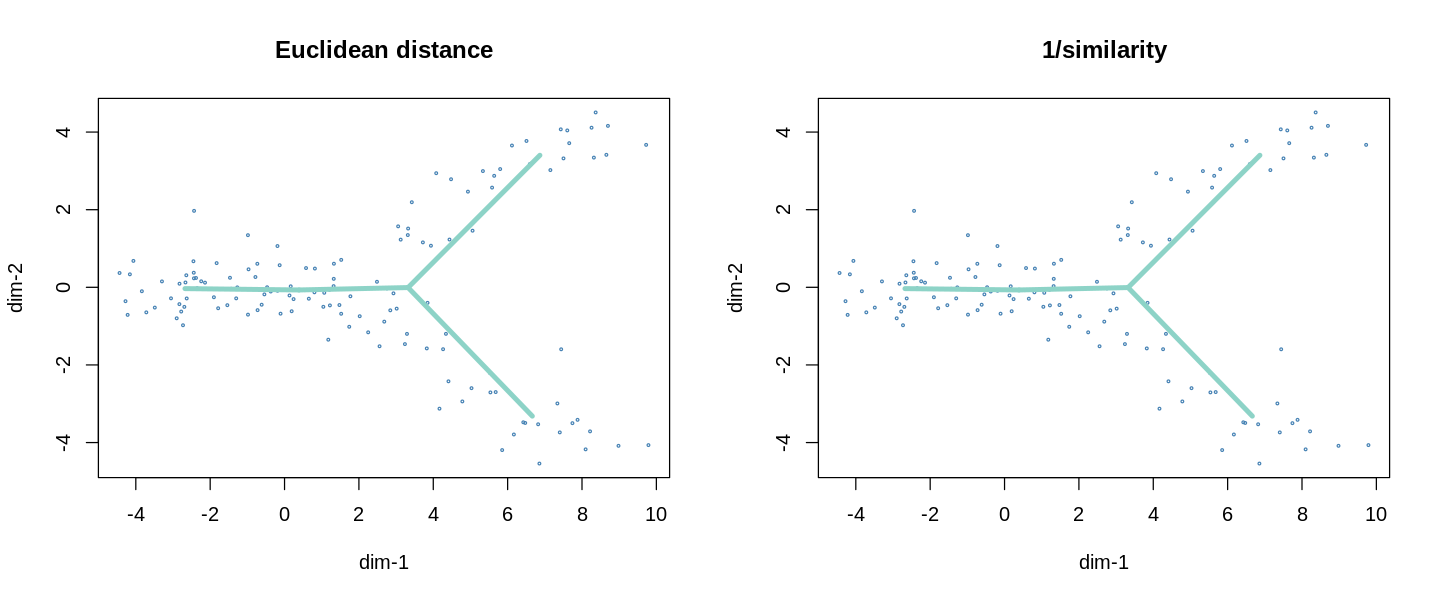

In [57]:
options(repr.plot.width = 12, repr.plot.height = 5)
par(mfrow = c(1, 2))
plot(rd, col = "steelblue", cex = 0.3, main = "Euclidean distance")
lines(lin4, cex = 0.1, lwd = 4, type = "l")
plot(rd, col = "steelblue", cex = 0.3, main = "1/similarity")
lines(lin5, cex = 0.1, lwd = 4, type = "l")